In [28]:
#skip this block is already installed

'''
!pip install xgboost
!pip install lightgbm
!pip install pandas
!pip install matplotlib
!pip install seaborn
'''


'\n!pip install xgboost\n!pip install lightgbm\n!pip install pandas\n!pip install matplotlib\n!pip install seaborn\n'

In [47]:
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneOut

from matplotlib import pyplot
from xgboost import plot_importance

color = sns.color_palette()

sys.path.insert(0,"/Users/fellipeferreira/OneDrive/CIT - Master Data Science/Semester 3/project/final-project-datascience-mtu/code/")  # path contains python_file.py
import utils
from utils import get_name_from_value

In [48]:
PATH_TO_FILE = "../../psykose/schizophrenia-features.csv"

#my baseline features
#PATH_TO_FILE = "../my_baseline.csv"

_PARAMS_LORGREG = {
    "penalty": "l2", "C": 1.0, "class_weight": "balanced",
    "random_state": 2018, "solver": "liblinear", "n_jobs": 1
}

_PARAMS_RFC = {
    "n_estimators": 10,
    "max_features": "auto", "max_depth": None,
    "min_samples_split": 2, "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_leaf_nodes": None, "bootstrap": True,
    "oob_score": False, "n_jobs": -1, "random_state": 2018,
    "class_weight": "balanced"
}

_PARAMS_DTC = {
    
    "max_features": "auto", "max_depth": None,
    "min_samples_split": 2, "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_leaf_nodes": None, 
     "random_state": 2018,
    "class_weight": "balanced"
    
}

_PARAMS_XGB = {
    "nthread":16, "learning_rate": 0.3, "gamma": 0, "max_depth": 6, "verbosity": 0,
    "min_child_weight": 1, "max_delta_step": 0, "subsample": 1.0, "colsample_bytree": 1.0,
    "objective":"binary:logistic", "num_class":1, "eval_metric":"logloss", "seed":2018,
}

_PARAMS_LIGHTGB = {
    "task": "train", "num_class":1, "boosting": "gbdt", "verbosity": -1,
    "objective": "binary", "metric": "binary_logloss", "metric_freq":50, "is_training_metric":False,
    "max_depth":4, "num_leaves": 31, "learning_rate": 0.01, "feature_fraction": 1.0, "bagging_fraction": 1.0,
    "bagging_freq": 0, "bagging_seed": 2018, "num_threads":16
}

# Data Frame to collect all results of the classifiers
df_result = pd.DataFrame()
df_feature_importance = pd.DataFrame()
df_leave_one_out = pd.DataFrame()

In [49]:
data = pd.read_csv(PATH_TO_FILE)

dataX = data.copy().drop(["class", "class_str", "userid"], axis=1)
dataY = data["class"].copy()

#standardize the data
scaler = pp.StandardScaler(copy=True)
dataX.loc[:, dataX.columns] = scaler.fit_transform(dataX[dataX.columns])


testset_size = 0.5

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    dataX,
    dataY,
    test_size=testset_size,
    random_state=2019,
    stratify=dataY
)

In [50]:
def plot_prc_curve(y_preds, y_trues, title=None):
    
    precision, recall, _ = metrics.precision_recall_curve(
        y_trues,
        y_preds
    )

    average_precision = metrics.average_precision_score(
        y_trues,
        y_preds
    )

    print("Average Precision = %.2f" % average_precision)
    
    plt.step(recall, precision, color="k", alpha=0.7, where="post")
    plt.fill_between(recall, precision, step="post", alpha=0.3, color="k")

    if title is None:
        title = "PRC: Average Precision = %.2f" % average_precision

    plt.title(title)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.show()
    
    return average_precision

def plot_roc_curve(y_preds, y_trues, title=None):
    
    fpr, tpr, _ = metrics.roc_curve(y_trues, y_preds)

    auc_roc = metrics.auc(fpr, tpr)

    print("AUCROC = %.2f" % auc_roc)

    if title is None:
        title = "AUCROC = %.2f" % auc_roc

    plt.title(title)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
    plt.plot(fpr, tpr, color="r", lw=2, label="ROC curve")
    plt.plot([0, 1], [0, 1], color="k", lw=2, linestyle="--")

    plt.show()
    
    return auc_roc


def model_predict_k_fold( train_func, pred_func, model=None, n_splits=10, shuffle=True, random_state=2018 ):
     
    y_preds = []
    y_trues = []

    k_fold = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):
        
        x_fold_train, x_fold_test = X_TRAIN.iloc[train_index, :], X_TRAIN.iloc[fold_index, :]
        y_fold_train, y_fold_test = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[fold_index]

        model = train_func( model, x_fold_train, y_fold_train, x_fold_test, y_fold_test )
        y_pred = pred_func( model, x_fold_test )

        y_preds.extend( list(y_pred) )
        y_trues.extend( list(y_fold_test) )

    return model, np.array(y_preds), np.array(y_trues)



def leave_one_out(train_func, pred_func, model=None):
    y_preds = []
    y_trues = []

    loo = LeaveOneOut()

    for train_index, fold_index in loo.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):
        x_fold_train, x_fold_test = X_TRAIN.iloc[train_index, :], X_TRAIN.iloc[fold_index, :]
        y_fold_train, y_fold_test = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[fold_index]

        model = train_func(model, x_fold_train, y_fold_train, x_fold_test, y_fold_test)
        y_pred = pred_func(model, x_fold_test)

        y_preds.extend(list(y_pred))
        y_trues.extend(list(y_fold_test))

    return model, np.array(y_preds), np.array(y_trues)




# Logistic Regression

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       201
           1       0.75      0.82      0.78       142

    accuracy                           0.81       343
   macro avg       0.81      0.81      0.81       343
weighted avg       0.82      0.81      0.81       343

Average Precision = 0.90


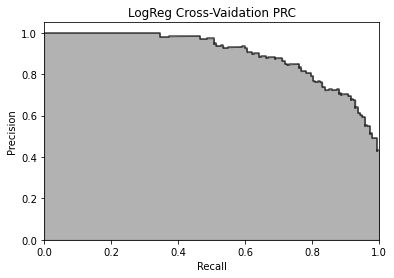

AUCROC = 0.91


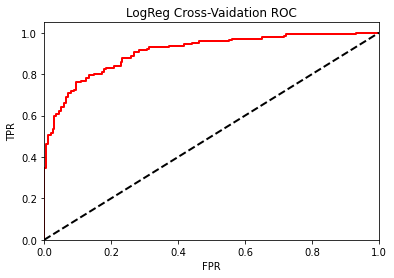

Average Precision = 0.89


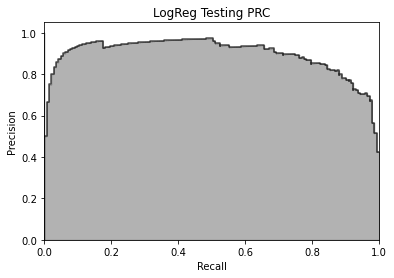

AUCROC = 0.93


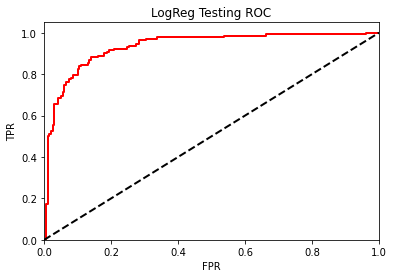

Feature: 0, Score: 0.75628
Feature: 1, Score: -2.53100
Feature: 2, Score: 0.97723


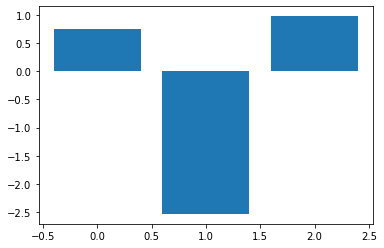

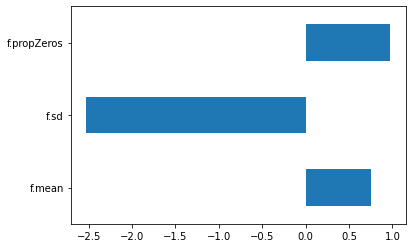

In [51]:
def logreg_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def logreg_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

logreg = LogisticRegression( **_PARAMS_LORGREG )

logreg, logreg_y_preds, logreg_y_trues = model_predict_k_fold( logreg_train_func, logreg_pred_func, logreg )
logreg_test_preds = logreg_pred_func( logreg, X_TEST )

#Leave one out
logreg_loo = LogisticRegression(**_PARAMS_LORGREG)
logreg_loo, logreg_y_preds_loo, logreg_y_trues_loo = leave_one_out( logreg_train_func, logreg_pred_func, logreg_loo )

print(classification_report(logreg_y_trues_loo, logreg_y_preds_loo.round()))
dict_report = classification_report(logreg_y_trues_loo, logreg_y_preds_loo.round(), output_dict=True)
for key, value in dict_report.items():
    row_loo = {"Classifier": "Logistic Regression" }
    if isinstance(value, dict):
        row_loo["Class"] = get_name_from_value(key)
        row_loo.update(value)

        #collect the result for leave one out
        df_leave_one_out = df_leave_one_out.append(row_loo, ignore_index=True )




#precision-recall curves (PRC)
#Receiver-operator curves (ROC)
average_precision = plot_prc_curve( logreg_y_preds, logreg_y_trues, "LogReg Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( logreg_y_preds, logreg_y_trues, "LogReg Cross-Vaidation ROC" )

plot_prc_curve( logreg_test_preds, Y_TEST, "LogReg Testing PRC" )
plot_roc_curve( logreg_test_preds, Y_TEST, "LogReg Testing ROC" )


#collect the result
row_stats = {'classifier': "Logistic Regression", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )

# get importance
importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

(pd.Series(logreg.coef_[0], index=X_TRAIN.columns)
  # .nlargest(4)
   .plot(kind='barh'))


series_features = pd.Series(logreg.coef_[0], index=X_TRAIN.columns)
row_features = {'classifier': "Logistic Regression"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# Random Forest

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       201
           1       0.78      0.71      0.75       142

    accuracy                           0.80       343
   macro avg       0.80      0.79      0.79       343
weighted avg       0.80      0.80      0.80       343

Average Precision = 0.83


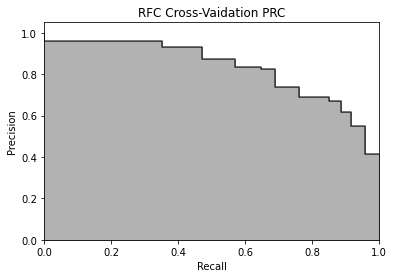

AUCROC = 0.88


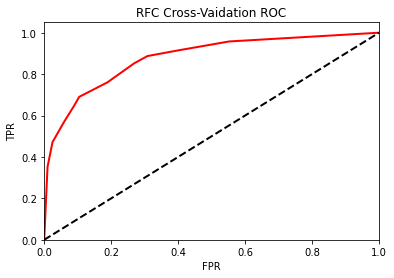

Average Precision = 0.85


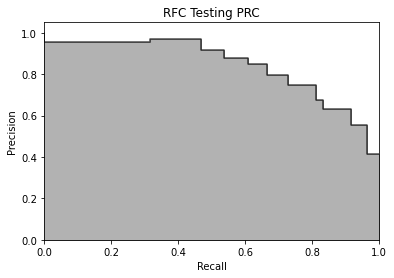

AUCROC = 0.88


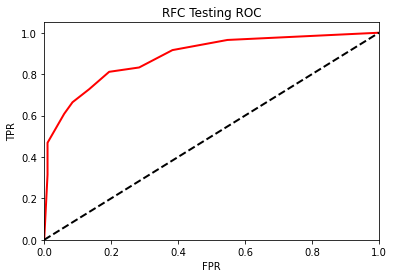

Feature: 0, Score: 0.31218
Feature: 1, Score: 0.30368
Feature: 2, Score: 0.38414


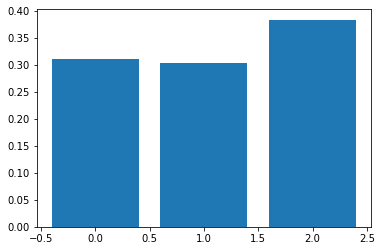

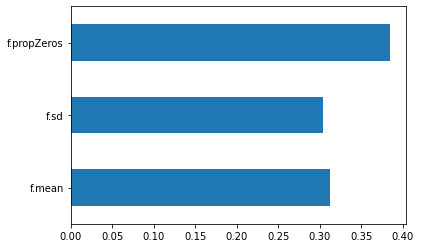

In [52]:
def rfc_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def rfc_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

rfc = RandomForestClassifier( **_PARAMS_RFC )

rfc, rfc_y_preds, rfc_y_trues = model_predict_k_fold( rfc_train_func, rfc_pred_func, rfc )
rfc_test_preds = rfc_pred_func( rfc, X_TEST )

#Leave one out
rfc_loo = RandomForestClassifier(**_PARAMS_RFC)
rfc_loo, rfc_y_preds_loo, rfc_y_trues_loo = leave_one_out( rfc_train_func, rfc_pred_func, rfc_loo )
print(classification_report(rfc_y_trues_loo, rfc_y_preds_loo.round()))

dict_report = classification_report(rfc_y_trues_loo, rfc_y_preds_loo.round(), output_dict=True)
for key, value in dict_report.items():
    row_loo = {"Classifier": "Random Forest" }
    if isinstance(value, dict):
        row_loo["Class"] = get_name_from_value(key)
        row_loo.update(value)

        #collect the result for leave one out
        df_leave_one_out = df_leave_one_out.append(row_loo, ignore_index=True )


average_precision = plot_prc_curve( rfc_y_preds, rfc_y_trues, "RFC Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( rfc_y_preds, rfc_y_trues, "RFC Cross-Vaidation ROC" )

plot_prc_curve( rfc_test_preds, Y_TEST, "RFC Testing PRC" )
plot_roc_curve( rfc_test_preds, Y_TEST, "RFC Testing ROC" )



#collect the result
row_stats = {'classifier': "Random Forest", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


# get importance
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#
(pd.Series(importance, index=X_TRAIN.columns)
   #.nlargest(4)
   .plot(kind='barh'))



series_features = pd.Series(importance, index=X_TRAIN.columns)
row_features = {'classifier': "Random Forest"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)


# Decision Tree


              precision    recall  f1-score   support

           0       0.81      0.86      0.83       201
           1       0.78      0.71      0.75       142

    accuracy                           0.80       343
   macro avg       0.80      0.79      0.79       343
weighted avg       0.80      0.80      0.80       343

Average Precision = 0.67


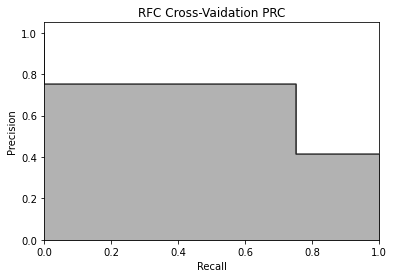

AUCROC = 0.79


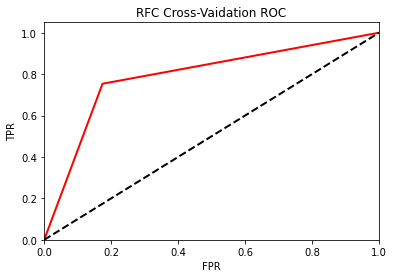

Average Precision = 0.65


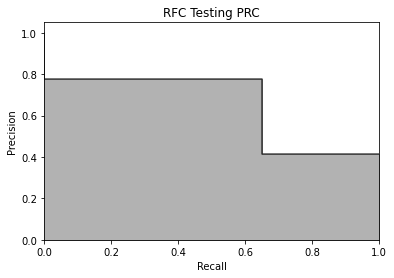

AUCROC = 0.76


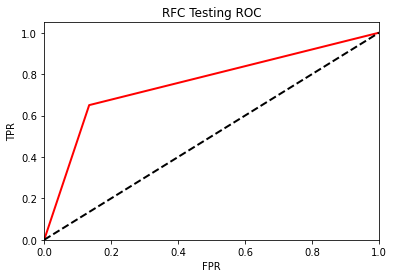

Feature: 0, Score: 0.31218
Feature: 1, Score: 0.30368
Feature: 2, Score: 0.38414


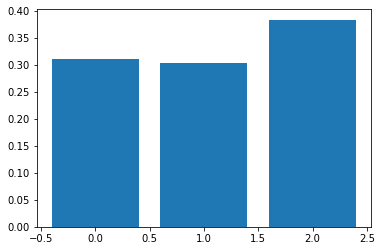

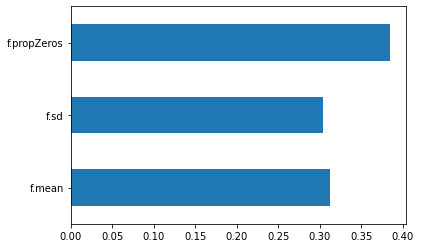

In [53]:
from sklearn.tree import DecisionTreeClassifier

def dtc_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def dtc_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

dtc = DecisionTreeClassifier( **_PARAMS_DTC )

dtc, dtc_y_preds, dtc_y_trues = model_predict_k_fold( dtc_train_func, dtc_pred_func, dtc )
dtc_test_preds = dtc_pred_func( dtc, X_TEST )


#Leave one out
dtc_loo = RandomForestClassifier(**_PARAMS_RFC)
dtc_loo, dtc_y_preds_loo, dtc_y_trues_loo = leave_one_out( dtc_train_func, dtc_pred_func, dtc_loo )
print(classification_report(dtc_y_trues_loo, dtc_y_preds_loo.round()))

dict_report = classification_report(dtc_y_trues_loo, dtc_y_preds_loo.round(), output_dict=True)
for key, value in dict_report.items():
    row_loo = {"Classifier": "Decision Tree" }
    if isinstance(value, dict):
        row_loo["Class"] = get_name_from_value(key)
        row_loo.update(value)

        #collect the result for leave one out
        df_leave_one_out = df_leave_one_out.append(row_loo, ignore_index=True )



average_precision = plot_prc_curve( dtc_y_preds, dtc_y_trues, "RFC Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( dtc_y_preds, dtc_y_trues, "RFC Cross-Vaidation ROC" )

plot_prc_curve( dtc_test_preds, Y_TEST, "RFC Testing PRC" )
plot_roc_curve( dtc_test_preds, Y_TEST, "RFC Testing ROC" )



#collect the result
row_stats = {'classifier': "Decision Tree", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


# get importance
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#
(pd.Series(importance, index=X_TRAIN.columns)
   #.nlargest(4)
   .plot(kind='barh'))



series_features = pd.Series(importance, index=X_TRAIN.columns)
row_features = {'classifier': "Decision Tree"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)

# XGBoost

[0]	train-logloss:0.52960+0.00332	test-logloss:0.57012+0.00502
[50]	train-logloss:0.05792+0.00266	test-logloss:0.44842+0.06324
[100]	train-logloss:0.03801+0.00154	test-logloss:0.47500+0.06484
[150]	train-logloss:0.03095+0.00117	test-logloss:0.49538+0.06856
[200]	train-logloss:0.02699+0.00100	test-logloss:0.50710+0.07223
[208]	train-logloss:0.02652+0.00095	test-logloss:0.50716+0.07378
[0]	train-logloss:0.52456+0.00843	test-logloss:0.55789+0.02438
[50]	train-logloss:0.05394+0.00252	test-logloss:0.44143+0.07188
[100]	train-logloss:0.03569+0.00158	test-logloss:0.46783+0.07991
[150]	train-logloss:0.02896+0.00132	test-logloss:0.48263+0.08335
[200]	train-logloss:0.02548+0.00108	test-logloss:0.48647+0.08507
[206]	train-logloss:0.02517+0.00105	test-logloss:0.48747+0.08560
[0]	train-logloss:0.52402+0.00567	test-logloss:0.56095+0.01518
[50]	train-logloss:0.05695+0.00276	test-logloss:0.46690+0.09300
[100]	train-logloss:0.03712+0.00124	test-logloss:0.49733+0.10916
[150]	train-logloss:0.03004+0.0004

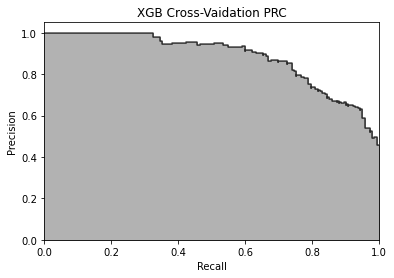

AUCROC = 0.90


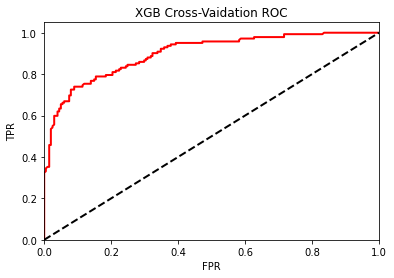

Average Precision = 0.88


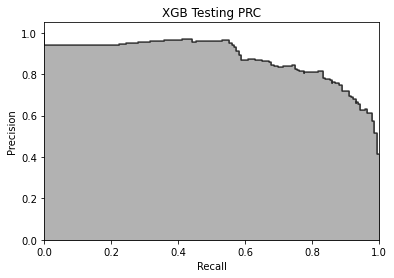

AUCROC = 0.91


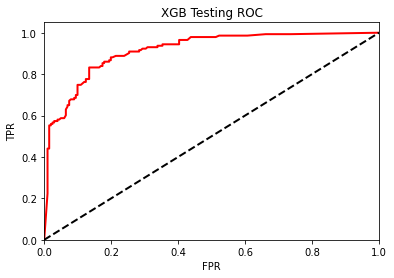

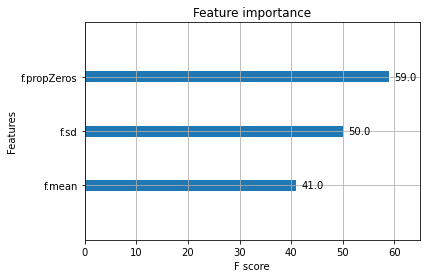

In [54]:
def xgb_train_func(model, x_train, y_train, x_test, y_test):
    dtrain = xgb.DMatrix(data=x_train, label=y_train)

    bst = xgb.cv(_PARAMS_XGB,
        dtrain,
        num_boost_round=2000,
        nfold=5,
        early_stopping_rounds=200,
        verbose_eval=50
    )

    best_rounds = np.argmin(bst["test-logloss-mean"])
    bst = xgb.train(_PARAMS_XGB, dtrain, best_rounds)
    return bst

def xgb_pred_func(model, data):
    data = xgb.DMatrix(data=data)
    pred = model.predict(data)
    return pred

xgb_model, xgb_y_preds, xgb_y_trues = model_predict_k_fold( xgb_train_func, xgb_pred_func )
xgb_test_preds = xgb_pred_func( xgb_model, X_TEST )

average_precision = plot_prc_curve( xgb_y_preds, xgb_y_trues, "XGB Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( xgb_y_preds, xgb_y_trues, "XGB Cross-Vaidation ROC" )

plot_prc_curve( xgb_test_preds, Y_TEST, "XGB Testing PRC" )
plot_roc_curve( xgb_test_preds, Y_TEST, "XGB Testing ROC" )



#collect the result
row_stats = {'classifier': "XGBoost", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


# plot feature importance
plot_importance(xgb_model)
pyplot.show()



series_features = pd.Series(importance, index=X_TRAIN.columns)
row_features = {'classifier': "XGBoost"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# LightGBM

Average Precision = 0.90


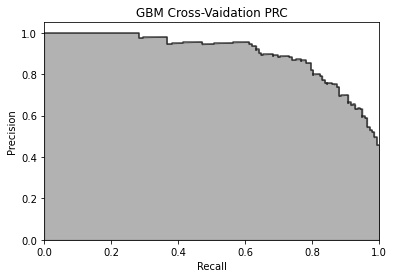

AUCROC = 0.92


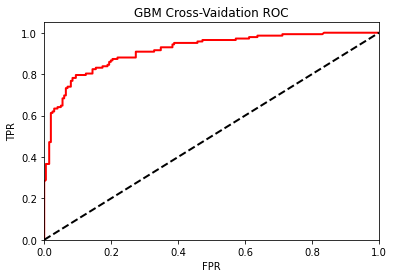

Average Precision = 0.88


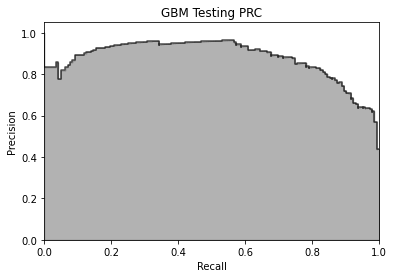

AUCROC = 0.92


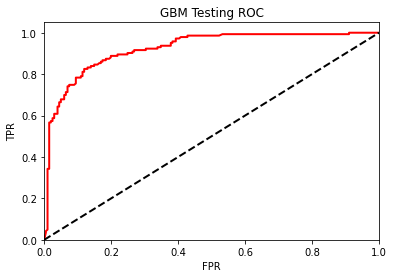

Plotting feature importances...


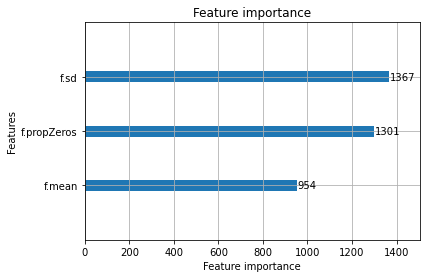

In [55]:
def gbm_train_func(model, x_train, y_train, x_test, y_test):
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    gbm = lgb.train(
        _PARAMS_LIGHTGB,
        lgb_train,
        verbose_eval=False,
        num_boost_round=2000,
        valid_sets=lgb_eval,
        early_stopping_rounds=200
    )

    return gbm

def gbm_pred_func(model, data):
    return model.predict(data, num_iteration=model.best_iteration)

gbm, gbm_y_preds, gbm_y_trues = model_predict_k_fold( gbm_train_func, gbm_pred_func )
gbm_test_preds = gbm_pred_func( gbm, X_TEST )

average_precision = plot_prc_curve( gbm_y_preds, gbm_y_trues, "GBM Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( gbm_y_preds, gbm_y_trues, "GBM Cross-Vaidation ROC" )

plot_prc_curve( gbm_test_preds, Y_TEST, "GBM Testing PRC" )
plot_roc_curve( gbm_test_preds, Y_TEST, "GBM Testing ROC" )




#collect the result
row_stats = {'classifier': "LightGBM", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()



df_feature_importance_2 = (
    pd.DataFrame({
        'feature': gbm.feature_name(),
        'importance': gbm.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)

series_features = pd.Series(gbm.feature_importance(), index=gbm.feature_name())
row_features = {'classifier': "LightGBM"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# Ensemble

Average Precision = 0.90


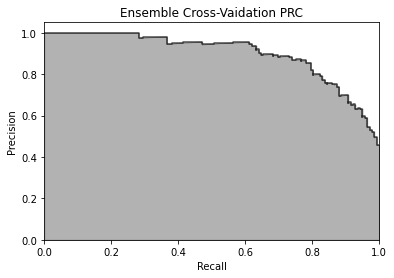

AUCROC = 0.92


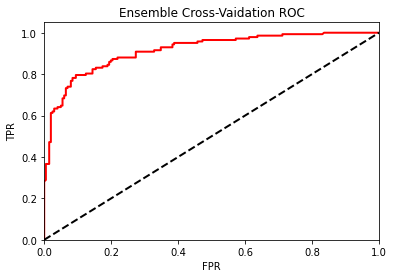

Average Precision = 0.88


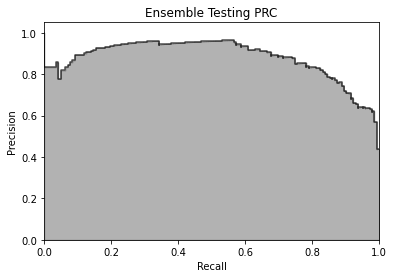

AUCROC = 0.92


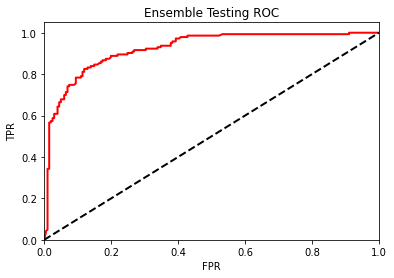

Plotting feature importances...


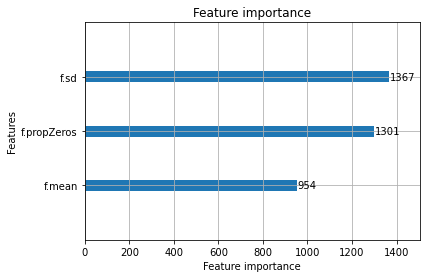

In [56]:
def ensemble_train_func(model, x_train, y_train, x_test, y_test):
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    ensemble = lgb.train(
        _PARAMS_LIGHTGB,
        lgb_train,
        verbose_eval=False,
        num_boost_round=2000,
        valid_sets=lgb_eval,
        early_stopping_rounds=200
    )

    return ensemble

def ensemble_pred_func(model, data):
    return model.predict(data, num_iteration=model.best_iteration)

ensemble, ensemble_y_preds, ensemble_y_trues = model_predict_k_fold( ensemble_train_func, ensemble_pred_func )
ensemble_test_preds = ensemble_pred_func( ensemble, X_TEST )

average_precision = plot_prc_curve( ensemble_y_preds, ensemble_y_trues, "Ensemble Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( ensemble_y_preds, ensemble_y_trues, "Ensemble Cross-Vaidation ROC" )

plot_prc_curve( ensemble_test_preds, Y_TEST, "Ensemble Testing PRC" )
plot_roc_curve( ensemble_test_preds, Y_TEST, "Ensemble Testing ROC" )


#collect the result
row_stats = {'classifier': "Ensemble", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )



print('Plotting feature importances...')
ax = lgb.plot_importance(ensemble)
plt.show()




series_features = pd.Series(ensemble.feature_importance(), index=ensemble.feature_name())
row_features = {'classifier': "Ensemble"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)


In [57]:
df_result = df_result[['classifier', 'Average Precision', 'AUCROC', 'testset_size']]
df_result


,classifier,Average Precision,AUCROC,testset_size
0,Logistic Regression,0.896156,0.908731,0.5
1,Random Forest,0.832536,0.877672,0.5
2,Decision Tree,0.669835,0.789696,0.5
3,XGBoost,0.884323,0.899989,0.5
4,LightGBM,0.900736,0.915703,0.5
5,Ensemble,0.900736,0.915703,0.5


In [58]:
#df_feature_importance = df_feature_importance[['classifier', 'mean', 'sd', 'prop_zero', 'kurtosis', 'skew']]
#df_feature_importance = df_feature_importance[['classifier', 'mean', 'sd', 'prop_zero']]
df_feature_importance

,classifier,f.mean,f.sd,f.propZeros
0,Logistic Regression,0.756276,-2.531000,0.977229
1,Random Forest,0.312179,0.303677,0.384144
2,Decision Tree,0.312179,0.303677,0.384144
3,XGBoost,0.312179,0.303677,0.384144
4,LightGBM,954.000000,1367.000000,1301.000000
5,Ensemble,954.000000,1367.000000,1301.000000


In [59]:
df_leave_one_out = df_leave_one_out[['Classifier', 'Class', 'precision', 'recall', 'f1-score', 'support']]
df_leave_one_out

,Classifier,Class,precision,recall,f1-score,support
0,Logistic Regression,CONTROL,0.865591,0.800995,0.832041,201.0
1,Logistic Regression,PATIENT,0.745223,0.823944,0.782609,142.0
2,Logistic Regression,macro avg,0.805407,0.812469,0.807325,343.0
3,Logistic Regression,weighted avg,0.815760,0.810496,0.811577,343.0
4,Random Forest,CONTROL,0.808411,0.860697,0.833735,201.0
5,Random Forest,PATIENT,0.782946,0.711268,0.745387,142.0
6,Random Forest,macro avg,0.795678,0.785982,0.789561,343.0
7,Random Forest,weighted avg,0.797869,0.798834,0.797160,343.0
8,Decision Tree,CONTROL,0.808411,0.860697,0.833735,201.0
9,Decision Tree,PATIENT,0.782946,0.711268,0.745387,142.0
